# DM-25824: Rotator/CCW synchronization test

This notebook contains queries to the EFD to analyse the data from the CCW-Rotator synchronization test.

The test consists of performing repetitive movements with the Rotator to see if the CCW can keep up.

The test can be driven by a notebook (`CCW-Rotator-IT.ipynb`) or using a Script (`maintel/integration_tests/ccw_rotator_stress.py` in `ts_standardscripts`).

In [1]:
import numpy as np
import pandas as pd

from astropy.time import Time
from datetime import timedelta, datetime

import lsst_efd_client

import matplotlib.pyplot as plt

plt.jet()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters();

<Figure size 432x288 with 0 Axes>

In [2]:
client = lsst_efd_client.EfdClient('ncsa_teststand_efd')

## Querying data from EFD

The time set below is for when the test was originally performed at NCSA. This can be modified to query/analyse data taken on different runs.

In [3]:
start = Time('2020-07-09T02:38:00') #this is UTC
end = Time('2020-07-09T04:05:00')

Basically we want to compare the Rotator position, which is in the `Rotator.Application` topic, and the Camera Cable Wrap position, in the `MTMount.Camera_Cable_Wrap` topic.

One thing to remember is that, since the data is sent asynchronously by two different components, we need to resample them to the same time domain in order to be able to compare them. This is done using the `resample` utility method provided by `lsst_efd_client`, and it performs a simple interpolation to resample one data frame into another.

In [4]:
rot = await client.select_time_series('lsst.sal.Rotator.Application', 'Position, Demand', 
                                     start.tai, end.tai)

ccw = await client.select_time_series('lsst.sal.MTMount.Camera_Cable_Wrap', 'CCW_Angle_1, CCW_Speed_1', 
                                     start.tai, end.tai)

rot_ccw_resampled = lsst_efd_client.resample(rot, ccw)

## Rotator vs CCW Position.

The plot below show a direct comparison of the Rotator position with the CCW position.

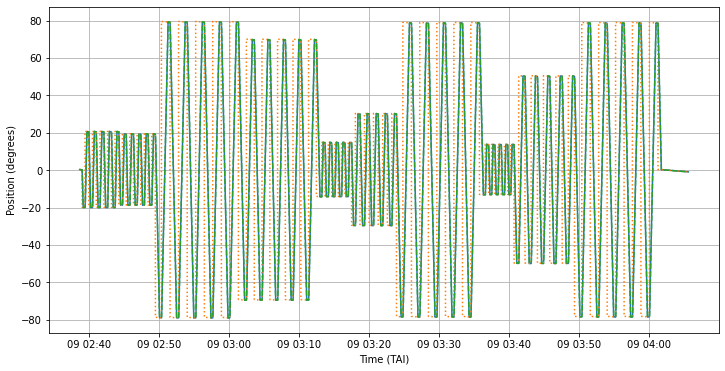

In [5]:
fig = plt.figure(1, (12, 6))

plt.plot(rot.Position,'-')
plt.plot(rot.Demand,':')
plt.plot(ccw.CCW_Angle_1,'--')

plt.ylabel("Position (degrees)")
plt.xlabel("Time (TAI)")

plt.grid()

The direct comparison above, althought good to understand what movement the Rotator was performing, does not allow a good comparison of how good the CCW was in following it. To highlight that, we use the resampled data to show the difference between Rotator and CCW position.

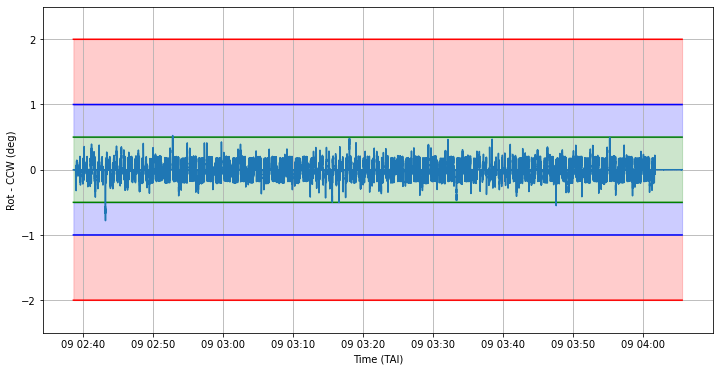

In [6]:
fig = plt.figure(1, (12, 6))

plt.fill_between(rot_ccw_resampled.index, 
                 np.zeros(len(rot_ccw_resampled.index))-0.5, 
                 np.zeros(len(rot_ccw_resampled.index))+0.5, 
                 alpha=0.2, color='g')
plt.fill_between(rot_ccw_resampled.index, 
                 np.zeros(len(rot_ccw_resampled.index))+0.5, 
                 np.zeros(len(rot_ccw_resampled.index))+1.0, 
                 alpha=0.2, color='b')
plt.fill_between(rot_ccw_resampled.index, 
                 np.zeros(len(rot_ccw_resampled.index))-0.5, 
                 np.zeros(len(rot_ccw_resampled.index))-1.0, 
                 alpha=0.2, color='b')
plt.fill_between(rot_ccw_resampled.index, 
                 np.zeros(len(rot_ccw_resampled.index))+1.0, 
                 np.zeros(len(rot_ccw_resampled.index))+2.0, 
                 alpha=0.2, color='r')
plt.fill_between(rot_ccw_resampled.index, 
                 np.zeros(len(rot_ccw_resampled.index))-1.0, 
                 np.zeros(len(rot_ccw_resampled.index))-2.0, 
                 alpha=0.2, color='r')

plt.plot(rot_ccw_resampled.index, np.zeros_like(rot_ccw_resampled.index)+2.0, "r-")
plt.plot(rot_ccw_resampled.index, np.zeros_like(rot_ccw_resampled.index)+1.0, "b-")
plt.plot(rot_ccw_resampled.index, np.zeros_like(rot_ccw_resampled.index)+0.5, "g-")

plt.plot(rot_ccw_resampled.index, np.zeros_like(rot_ccw_resampled.index)-0.5, "g-")
plt.plot(rot_ccw_resampled.index, np.zeros_like(rot_ccw_resampled.index)-1.0, "b-")
plt.plot(rot_ccw_resampled.index, np.zeros_like(rot_ccw_resampled.index)-2.0, "r-")


plt.plot(rot_ccw_resampled.Position-rot_ccw_resampled.CCW_Angle_1, '-')

plt.ylabel("Rot - CCW (deg)")
plt.xlabel("Time (TAI)")

plt.ylim(-2.5, 2.5)
plt.grid()